In [67]:
import pandas as pd
import numpy as np
from symbol import Symbol
from index import Index
from portifolio import Portifolio
from datetime import datetime
import os

import matplotlib.pyplot as plt
from matplotlib import gridspec

from bqplot import pyplot as bplt
import seaborn as sns
from dateutil.relativedelta import relativedelta

sns.set(context='notebook', style="dark", palette="muted", color_codes=True)

%matplotlib inline

In [22]:
class Columns(object):
    OPEN = 'open'
    HIGH = 'high'
    LOW = 'low'
    CLOSE = 'close'
    VOLUME = 'volume'


def get(data, col):
    return(data[col])


# price = COL.CLOSE


indicators = [
    "MA", "EMA", "MOM", "ROC", "ATR", "BBANDS", "PPSR", "STOK", "STO",
    "TRIX", "ADX", "MACD", "MassI", "Vortex", "KST", "RSI", "TSI", "ACCDIST",
    "Chaikin", "MFI", "OBV", "FORCE", "EOM", "CCI", "COPP", "KELCH", "ULTOSC",
    "DONCH", "STDDEV"
]


class Settings(object):
    join = True
    col = Columns()


SETTINGS = Settings()


def out(settings, data, result):
    if not settings.join:
        return pd.DataFrame(result)
    else:
        data = data.join(result)
        return data

In [3]:
s= Symbol()
i = Index()
p = Portifolio()

In [10]:
fdata = s.get_symbol_hist('infy').set_index('date')['2016']
n = 5

In [14]:
data = fdata[['close']]
# SETTINGS.join = True

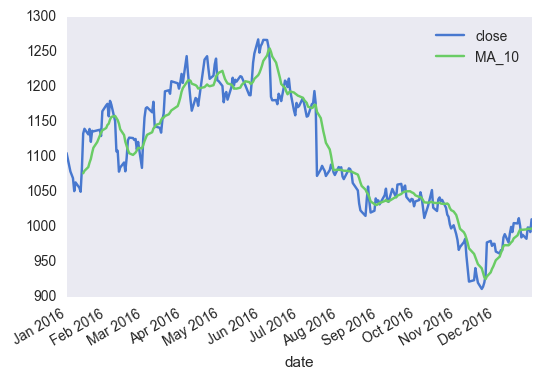

In [23]:
def MA(data, n, price='close'):
    """
    Moving Average
    """
    MA = data[price].rolling(window=n).mean().rename('MA_{n}'.format(n=n))
    return out(SETTINGS, data, MA)
n=10
MA(data, n).plot()

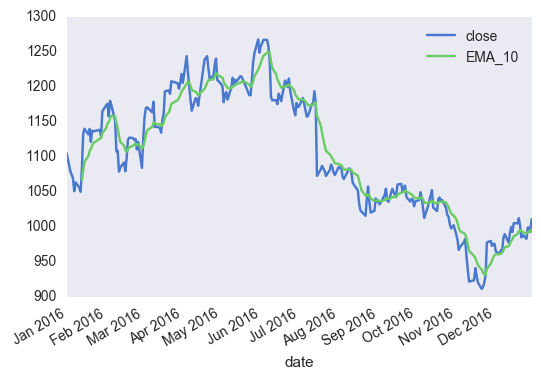

In [24]:
def EMA(data, n, price='close'):
    """
    Exponential Moving Average
    """
    EMA = data[price].ewm(span=n, min_periods=n - 1).mean().rename('EMA_{n}'.format(n=n))
    return out(SETTINGS, data, EMA)
n=10
EMA(data, n).plot()

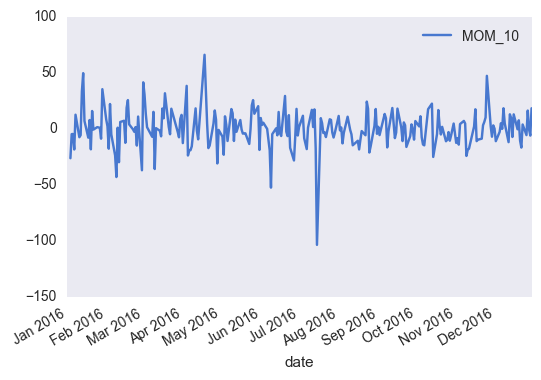

In [25]:
SETTINGS.join = False
def MOM(data, n, price='close'):
    """
    Momentum
    """
    MOM = data[price].diff().rename('MOM_{n}'.format(n=n))
    return out(SETTINGS, data, MOM)
n=10
MOM(data, n).plot()

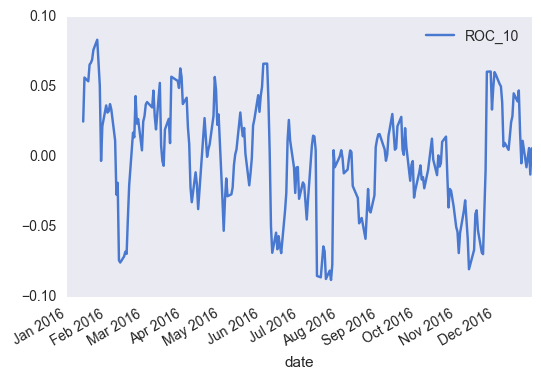

In [26]:
def ROC(data, n, price='close'):
    """
    Rate of Change
    """
    M = data[price].diff(n - 1)
    N = data[price].shift(n - 1)
    result = pd.Series(M / N, name='ROC_{n}'.format(n=n))
    return out(SETTINGS, data, result)
n=10
ROC(data, n).plot()

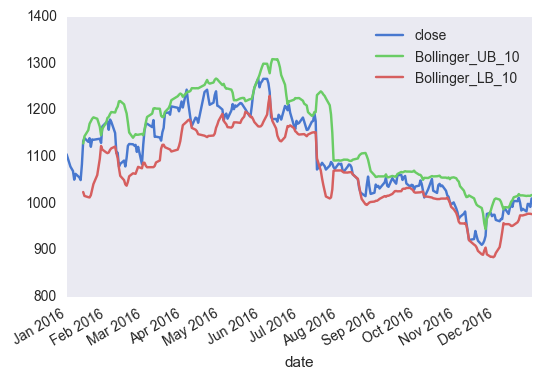

In [29]:
def BBANDS(data, n, price='close'):
    """
    Bollinger Bands
    """
    MA = data[price].rolling(n).mean()
    MSD = data[price].rolling(n).std()
    B1 = pd.Series(MA + 2* MSD, name='Bollinger_UB_{n}'.format(n=n), index=data.index)
    B2 = pd.Series(MA - 2* MSD, name='Bollinger_LB_{n}'.format(n=n), index=data.index)
    result = pd.DataFrame([B1, B2]).transpose()
    return out(SETTINGS, data, result)
BBANDS(data, 10).plot()

In [30]:
def PPSR(data):
    """
    Pivot Points, Supports and Resistances
    """
    PP = pd.Series((data['high'] + data['low'] + data['close']) / 3, name='PP')
    R1 = pd.Series(2 * PP - data['low'], name='R1')
    S1 = pd.Series(2 * PP - data['high'], name='S1')
    R2 = pd.Series(PP + data['high'] - data['low'], name='R2')
    S2 = pd.Series(PP - data['high'] + data['low'], name='S2')
    R3 = pd.Series(data['high'] + 2 * (PP - data['low']), name='R3')
    S3 = pd.Series(data['low'] - 2 * (data['high'] - PP), name='S3')
    result = pd.DataFrame([S3, S2, S1, PP, R1, R2, R3]).transpose()
    return out(SETTINGS, data, result)
SETTINGS.join = False
PPSR(fdata).tail()

,S3,S2,S1,PP,R1,R2,R3
date,,,,,,,
2016-12-26,955.000000,965.050000,973.900000,983.950000,992.800000,1002.850000,1011.700000
2016-12-27,963.433333,971.716667,985.333333,993.616667,1007.233333,1015.516667,1029.133333
2016-12-28,977.600000,986.300000,992.400000,1001.100000,1007.200000,1015.900000,1022.000000
2016-12-29,964.483333,976.316667,984.333333,996.166667,1004.183333,1016.016667,1024.033333
2016-12-30,978.983333,985.866667,998.233333,1005.116667,1017.483333,1024.366667,1036.733333


In [31]:
SETTINGS.join = True
def STOK(data, period=14):
    """
    Stochastic oscillator %K
    """
    H = data['high'].rolling(period).max()
    L = data['low'].rolling(period).min()
    k = (
        100 * ((data['close'] - L) / (H - L))
    )
    result = k.rename('STOK_FAST_{0}'.format(period)).round(2)
    return out(SETTINGS, data, result)

def STOD(data, period=14, smoothing=3):
    """
    Stochastic oscillator %D
    """
    SOk = STOK(data, period)['STOK_FAST_{0}'.format(period)]
    result = SOk.rolling(smoothing, min_periods=smoothing - 1).mean()
    result = result.rename('STOD_FAST_{0}'.format(period)).round(2)
    return out(SETTINGS, data, result)

def STOKD(data, period=14, smoothing=3):
    """
    Stochastic oscillator %D
    """
    SOk = STOK(data, period)['STOK_FAST_{0}'.format(period)]
    SOd = SOk.rolling(smoothing, min_periods=smoothing - 1).mean()
    SOd = SOd.rename('STOD_FAST_{0}'.format(period))
    result = pd.DataFrame([SOk, SOd]).transpose().round(2)
    return out(SETTINGS, data, result)

def STOKD_SLOW(data, period=14, smoothing=3):
    stokd_fast = STOKD(data, period, 3)
    SOk_slow = stokd_fast['STOK_FAST_{0}'.format(period)]
    SOk_slow = SOk_slow.rolling(3).mean()
    SOk_slow = SOk_slow.rename('STOK_SLOW_{0}'.format(period))
    SOd_slow = SOk_slow.rolling(period, min_periods=period - 1).mean()
    SOd_slow = SOd_slow.rename('STOD_SLOW_{0}'.format(period))
    result = pd.DataFrame([SOk_slow, SOd_slow]).transpose().round(2)
    return out(SETTINGS, data, result)

def STOKD_FULL(data, period=14, smoothing=3):
    stokd_fast = STOKD(data, period, 3)
    SOk_full = stokd_fast['STOK_FAST_{0}'.format(period)]
    SOk_full = SOk_full.rolling(period).mean()
    SOk_full = SOk_full.rename('STOK_SLOW_{0}'.format(period))
    SOd_full = SOk_full.rolling(period, min_periods=period - 1).mean()
    SOd_full = SOd_full.rename('STOD_SLOW_{0}'.format(period))
    result = pd.DataFrame([SOk_full, SOd_full]).transpose().round(2)
    return out(SETTINGS, data, result)

STOKD_FULL(fdata).tail()

,symbol,prev_close,open,high,low,last,close,vwap,volume,turnover,pct_deliverble,simple_returns,log_returns,daily_volatility,STOK_SLOW_14,STOD_SLOW_14
date,,,,,,,,,,,,,,,,
2016-12-26,infy,988.45,988.00,994.0,975.10,983.35,982.75,983.28,1606914.0,1.580050e+09,59.64,-0.005767,-0.005783,0.001417,70.12,74.33
2016-12-27,infy,982.75,982.75,1001.9,980.00,996.90,998.95,993.09,2456408.0,2.439426e+09,58.24,0.016484,0.016350,0.004005,68.93,74.99
2016-12-28,infy,998.95,1002.95,1009.8,995.00,999.00,998.50,1003.15,2738408.0,2.747040e+09,67.68,-0.000450,-0.000451,0.000110,66.10,75.04
2016-12-29,infy,998.50,1003.75,1008.0,988.15,990.00,992.35,997.88,3120062.0,3.113452e+09,73.84,-0.006159,-0.006178,0.001513,63.76,74.57
2016-12-30,infy,992.35,998.00,1012.0,992.75,1011.00,1010.60,1006.91,3633884.0,3.659012e+09,70.85,0.018391,0.018224,0.004464,64.51,73.87


In [47]:
SETTINGS.join = False
def TR(data):
    tr = pd.DataFrame()
    tr['TR1'] = abs(data['high'] - data['low'])
    tr['TR2'] = abs(data['high'] - data['prev_close'])
    tr['TR3'] = abs(data['low'] - data['prev_close'])
    tr['TrueRange'] = tr.max(axis=1)
    return tr.TrueRange
def ATR(data, period=14):
    tr = TR(data)
    atr = tr.ewm(span=period, min_periods=period).mean().rename('ATR_{0}'.format(period))
    return out(SETTINGS, data, atr)
ATR(fdata).tail()

,ATR_14
date,
2016-12-26,23.360798
2016-12-27,23.166025
2016-12-28,22.050555
2016-12-29,21.757148
2016-12-30,21.476195


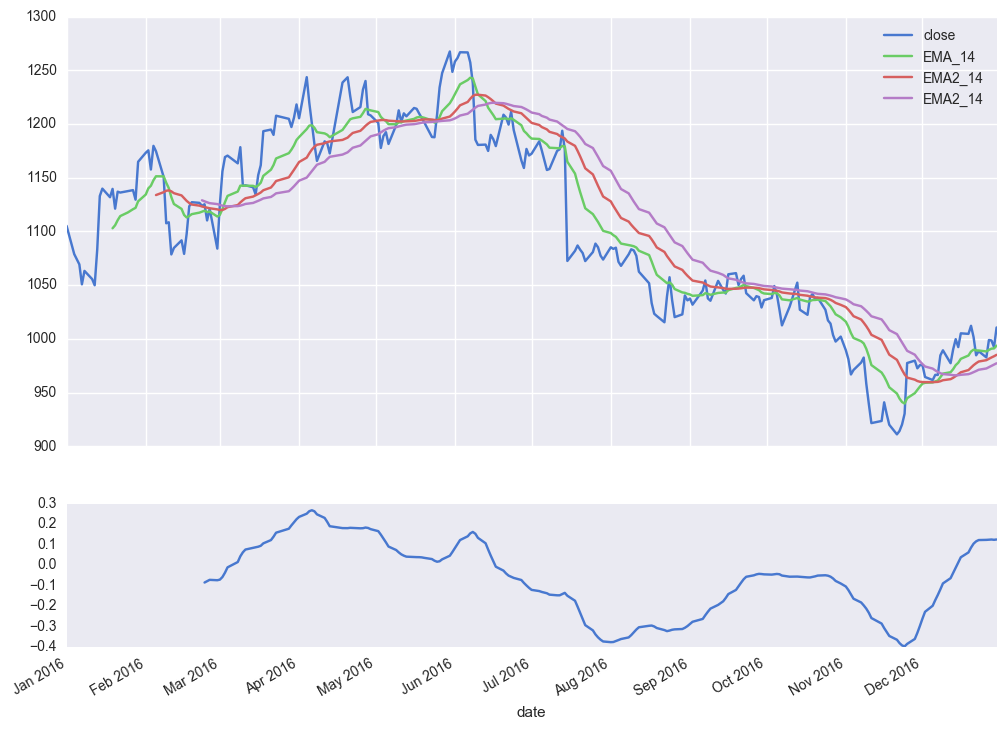

In [81]:
SETTINGS.join = True
def TRIX(data, period=14):
    """
    Trix
    """
    ema1 = data['close'].ewm(span=period, min_periods=period - 1).mean()
    ema1 = ema1.rename('EMA_{0}'.format(period))
    ema2 = ema1.ewm(span=period, min_periods=period - 1).mean()
    ema2 = ema2.rename('EMA2_{0}'.format(period))
    ema3 = ema2.ewm(span=period, min_periods=period - 1).mean()
    ema3 = ema3.rename('EMA2_{0}'.format(period))

    trix = ema3.pct_change() * 100
    trix = trix.rename('TRIX_{0}'.format(period))
    result = pd.DataFrame([ema1, ema2, ema3, trix]).T
    
    return out(SETTINGS, data, result)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[12,9], sharex=True, gridspec_kw={'height_ratios': [3, 1]})
# gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
TRIX(data).drop('TRIX_14', axis=1).plot(ax=ax[0])
ax[0].grid()
TRIX(data)['TRIX_14'].plot(ax=ax[1])

In [102]:
SETTINGS.join = False
def DM(data, period=14):
    
    high = data['high']
    low = data['low']
    
    moveup = high - high.shift(1)
    movedown = low.shift(1) - low
    
    pdm_condition = (moveup > movedown) & (moveup > 0)
    pdm = pdm_condition.replace(True, np.nan).fillna(moveup)
    pdm = pdm.ewm(span=period, min_periods=period - 1).mean()
    pdm = pdm.rename('PDM_{0}'.format(period))
    
    ndm_condition = (movedown > moveup) & (movedown > 0)
    ndm = ndm_condition.replace(True, np.nan).fillna(movedown)
    ndm = ndm.ewm(span=period, min_periods=period - 1).mean()
    ndm = ndm.rename('NDM_{0}'.format(period))
    
    dm = pd.DataFrame([pdm, ndm]).T
    return out(SETTINGS, data, dm)

def DI(data, period=14):
    dm = DM(data, period)[['PDM_{0}'.format(period), 'NDM_{0}'.format(period)]]
    dm.columns = ['pdm', 'ndm']
    atr = ATR(data, period)['ATR_{0}'.format(period)]
    
    pdi = 100 * (dm.pdm / atr)
    pdi = pdi.rename('PDI_{0}'.format(period))
    
    ndi = 100 * (dm.ndm / atr)
    ndi = ndi.rename('NDI_{0}'.format(period))
    
    di = pd.DataFrame([pdi, ndi]).T
    return out(SETTINGS, data, di)

def ADX(data, period=14):
    di = DI(data, period)[['PDI_{0}'.format(period), 'NDI_{0}'.format(period)]]
    di.columns = ['pdi', 'ndi']
    
    dx = 100 *(
        (di.pdi - di.ndi).abs() / (di.pdi + di.ndi)
    )
    
    adx = dx.ewm(span=period, min_periods=period - 1).mean()
    adx = pd.DataFrame([di.pdi, di.ndi, adx]).T
    adx.columns = [
        'PDI_{0}'.format(period), 'NDI_{0}'.format(period),
        'ADX_{0}'.format(period)
    ]
    return adx

ADX(fdata).tail()

,PDI_14,NDI_14,ADX_14
date,,,
2016-12-26,17.247155,18.936794,27.797725
2016-12-27,19.620098,16.549874,25.223138
2016-12-28,22.641171,15.068804,24.537459
2016-12-29,19.886967,17.433601,22.142299
2016-12-30,19.944215,15.306779,20.944056


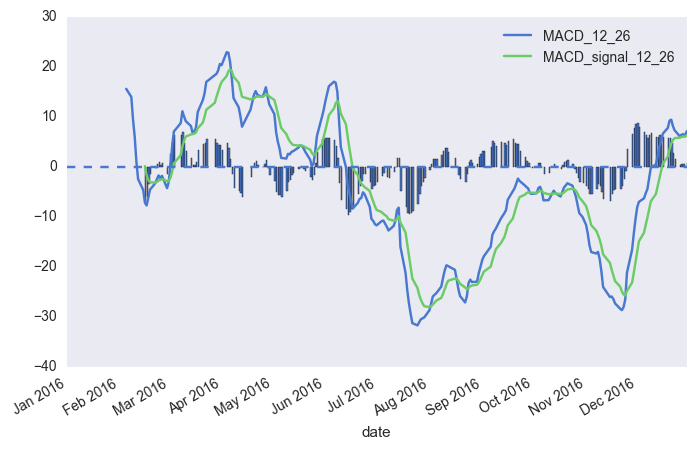

In [138]:
def MACD(data, n_fast=12, n_slow=26, signal=9,price='close'):
    """
    MACD, MACD Signal and MACD difference
    """
    price = data[price]
    EMAfast = price.ewm(span=n_fast, min_periods=n_fast - 1).mean()
    EMAslow = price.ewm(span=n_slow, min_periods=n_slow - 1).mean()
    macd = EMAfast - EMAslow
    macd = macd.rename('MACD_{0}_{1}'.format(n_fast, n_slow))
    macd_signal = macd.ewm(span=signal, min_periods=signal-1).mean()
    macd_signal = macd_signal.rename('MACD_signal_{0}_{1}'.format(n_fast, n_slow))
    macd_hist = macd - macd_signal
    macd_hist = macd_hist.rename('MACD_hist_{0}_{1}'.format(n_fast, n_slow))
    result = pd.DataFrame([macd, macd_signal, macd_hist]).transpose()
    return out(SETTINGS, data, result)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[8,5])
macd = MACD(data)
macd.ix[:, 0:2].plot(ax=ax)
plt.bar(left=macd.index, height=macd.ix[:, 2])
ax.axhline(y=0, linestyle='dashed')

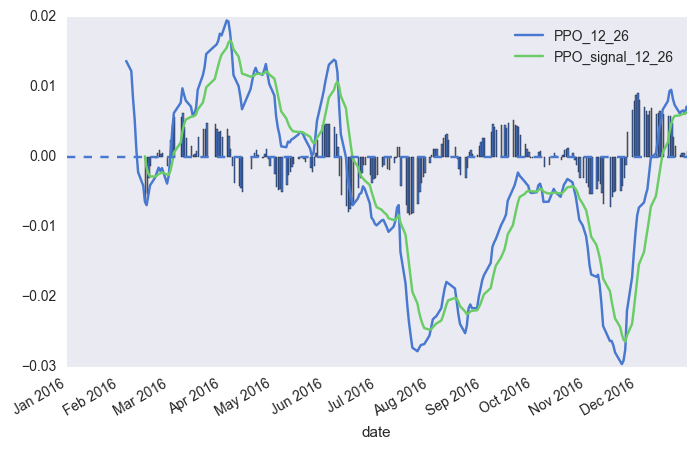

In [139]:
def PPO(data, n_fast=12, n_slow=26, signal=9,price='close'):
    """
    Percentage Price Oscillator
    """
    price = data[price]
    EMAfast = price.ewm(span=n_fast, min_periods=n_fast - 1).mean()
    EMAslow = price.ewm(span=n_slow, min_periods=n_slow - 1).mean()
    ppo = (EMAfast - EMAslow) / EMAslow
    ppo = ppo.rename('PPO_{0}_{1}'.format(n_fast, n_slow))
    ppo_signal = ppo.ewm(span=signal, min_periods=signal-1).mean()
    ppo_signal = ppo_signal.rename('PPO_signal_{0}_{1}'.format(n_fast, n_slow))
    ppo_hist = ppo - ppo_signal
    ppo_hist = ppo_hist.rename('PPO_hist_{0}_{1}'.format(n_fast, n_slow))
    result = pd.DataFrame([ppo, ppo_signal, ppo_hist]).transpose()
    return out(SETTINGS, data, result)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[8,5])
ppo = PPO(data)
ppo.ix[:, 0:2].plot(ax=ax)
plt.bar(left=ppo.index, height=ppo.ix[:, 2])
ax.axhline(y=0, linestyle='dashed')